# Coupling alternative electron pathways with stress response

Nima P. Saadat, Tim Nies, Marvin van Aalst, Brandon Hank, Büsra Demirtas, Oliver Ebenhöh, Anna Matuszyńska

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it


from scipy.integrate import trapezoid
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
from modelbase.ode import mca
from matplotlib.colors import TwoSlopeNorm

plt.style.use("./notebook.mplstyle")


def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])


# def test_version():
#     import pkg_resources
#     from distutils.version import LooseVersion

#     version = pkg_resources.get_distribution('modelbase').version
#     if not LooseVersion(version) >= LooseVersion("1.3.8"):
#         raise ImportError(f"You need modelbase >= 1.3.8 to run this script, got {version}")


def get_minmax(
    s: Simulator, t_end: float
) -> Tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    cmin = c.loc[t_end * 0.75 :, :].min()
    cmax = c.loc[t_end * 0.75 :, :].max()
    vmin = v.loc[t_end * 0.75 :, :].min()
    vmax = v.loc[t_end * 0.75 :, :].max()

    return cmin, cmax, vmin, vmax


def get_avg(s: Simulator, t_end: float) -> Tuple[pd.Series, pd.Series]:
    c = s.get_full_results_df()
    v = s.get_fluxes_df()

    vavg = pd.Series(
        trapezoid(v.loc[t_end * 0.75 :, :], x=v.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=v.columns,
    )

    cavg = pd.Series(
        trapezoid(c.loc[t_end * 0.75 :, :], x=c.loc[t_end * 0.75 :, :].index, axis=0)
        / (t_end - v.loc[t_end * 0.75 :, :].index.min()),
        index=c.columns,
    )

    return cavg.T, vavg.T


# test_version()

Could not find cannot import name 'dopri5' from 'assimulo.lib' (/home/elouen/Documents/PhotoModelBase/models/.pixi_envs/modelbase1/.pixi/envs/modelbase1/lib/python3.13/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (/home/elouen/Documents/PhotoModelBase/models/.pixi_envs/modelbase1/.pixi/envs/modelbase1/lib/python3.13/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (/home/elouen/Documents/PhotoModelBase/models/.pixi_envs/modelbase1/.pixi/envs/modelbase1/lib/python3.13/site-packages/assimulo/lib/__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
df = get_model().get_stoichiometric_df()

cols = list(df.columns)

rate = cols[4]
print('Rate:', rate)
new = df[df[rate] != 0]
new[rate]

Rate: v3ASC


DHA    1.0
MDA   -2.0
Name: v3ASC, dtype: float64

In [5]:
%%capture
cd analyses-paper/

In [6]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='Remember to label your axes', ylabel='Remember to label your axes'>)

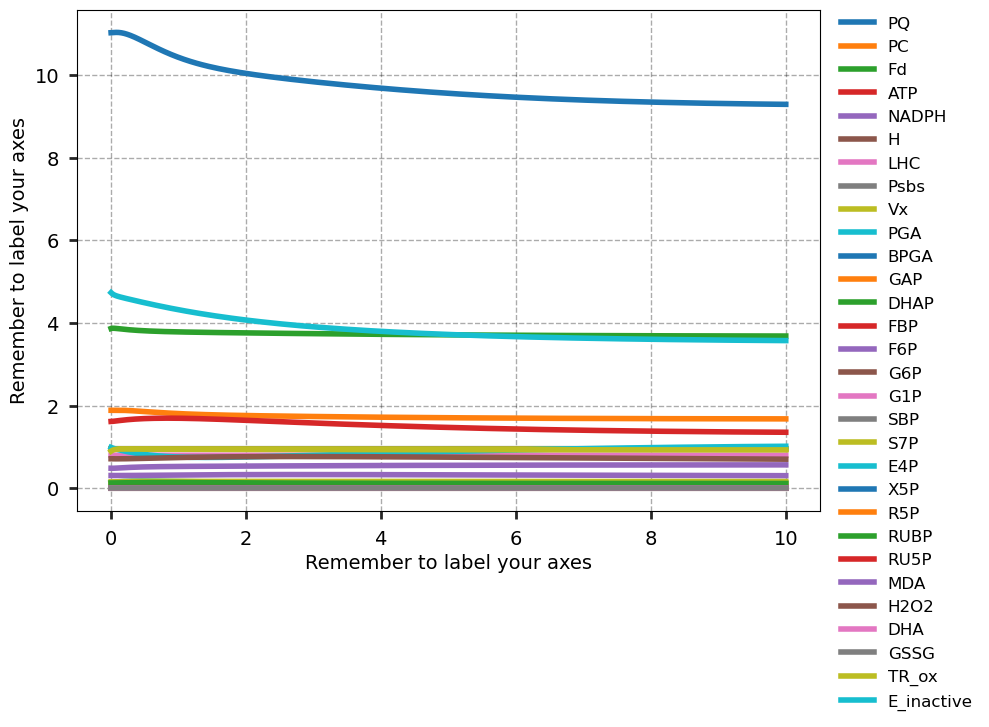

In [7]:
s = Simulator(get_model())
s.initialise(y0)
s.simulate(10)
s.plot()

## Figure 1: Schematic representation

<div style="max-width: 1000px; margin: auto;">

![PFT%202021%20model.png](../schemes/PFT-2021-model.png)


</div>

## Figure 2: Simulated PAM fluorescence trace

In [14]:
def pam_analysis(
    s: Simulator,
    t_relax: float,
    t_pulse: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    integrator_kwargs: Dict[str, Any] = None,
) -> None:
    if integrator_kwargs is None:
        integrator_kwargs = {}
    t = it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(32)))
    pfds = list(
        [pfd_dark, pfd_pulse] * 2
        + [pfd_illumination, pfd_pulse] * 10
        + [pfd_dark, pfd_pulse] * 8
    )
    for t_end, pfd in tqdm(zip(t, pfds), total=len(pfds), desc="simulation"):
        s.update_parameter("pfd", pfd)
        s.simulate(t_end, **integrator_kwargs)


def get_light(s: Simulator) -> np.ndarray:
    values = [
        list(it.repeat(par["pfd"], len(t)))
        for par, t in zip(s1.simulation_parameters, s1.get_time(concatenated=False))
    ]
    return np.fromiter(it.chain(*values), dtype="float")


def get_npq(
    s: Simulator,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculates the non-photochemical quenching from the extracted
    important points of the PAM simulations

    Returns
    -------
    Fm: Fm (first element of list) and Fm' values
    NPQ: Calculated NPQ values
    tm: Exact time points of peaks in PAM trace
    Fo: Fo (first element of list) and Ft' values
    to: Exact time points of Fo and Ft' values
    """
    # container for lists. Each list contains the positions of fluorescence values for one peak
    z = []

    # container for position of Fo'
    o = []
    cnt = 0

    light = get_light(s1)
    max_light = max(light)
    F = s.get_full_results_df()["Fluo"].values
    t = s.get_time()

    while cnt < len(light):
        if light[cnt] == max_light:
            # temporary container for all F==maxlight. For each peak it is renewed
            h = []
            while cnt != len(light) and light[cnt] == max(light):
                h.append(cnt)
                cnt += 1
            z.append(h)
            o.append(h[0] - 1)  # value directly at the bottom of peak is Fo
        else:
            cnt += 1
    # Fm is the maximal value for each peak sequence
    peaks = [i[np.argmax(F[i])] for i in z]
    Fm = F[peaks]
    tm = t[peaks]
    Fo = F[o]
    to = t[o]
    NPQ = (Fm[0] - Fm) / Fm
    return Fm, NPQ, tm, Fo, to

In [9]:
s1 = Simulator(get_model())
s1.initialise(y0)
s1.update_parameter("kcyc", 0.0)
s1.clear_results()
pam_analysis(
    s1,
    t_relax=120,
    t_pulse=0.8,
    pfd_dark=50,
    pfd_illumination=1000,
    pfd_pulse=5000,
)


simulation:   0%|          | 0/40 [00:00<?, ?it/s]

In [15]:
Fm, NPQ, tm, Fo, to = get_npq(s1)

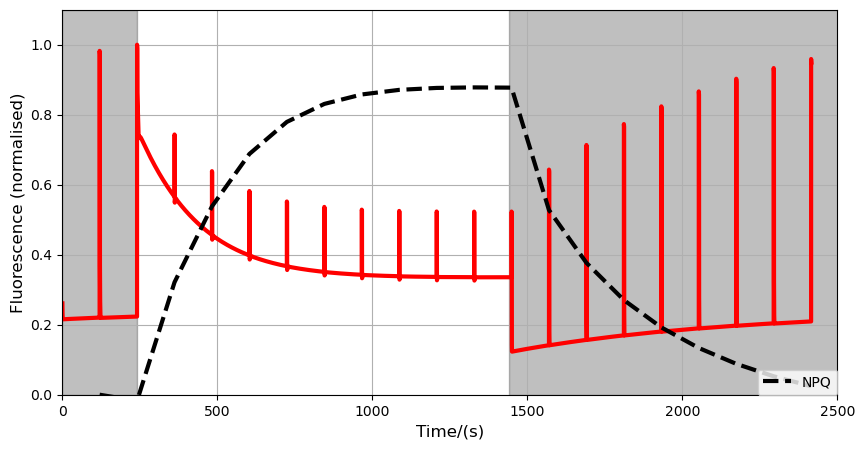

In [11]:
c = s1.get_full_results_df()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(c["Fluo"] / max(c["Fluo"]), color="red")
ax.plot(tm, NPQ, linestyle="dashed", color="black", label="NPQ")
ax.axvspan(0, 2 * 120, color=(0, 0, 0, 1 / 4))
ax.axvspan(12 * 120, 21 * 120, color=(0, 0, 0, 1 / 4))
ax.set(
    ylim=(0, 1.1),
    xlim=(0, 2500),
    xlabel="Time/(s)",
    ylabel="Fluorescence (normalised)",
)
ax.legend(loc="lower right")
plt.savefig("fig-2.png", bbox_inches="tight")
plt.show()

## Figure 3: Stationary fluxes

In [26]:
def plot_ppfd_petc_steady_state(
    v: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    v["vPS1"].plot(ax=ax1, label="rate through PS1")
    (v["vPS2"] * 2).plot(ax=ax1, label="LEF")
    (v["vCyc"] * 2).plot(ax=ax1, label="CEF")
    ax1.set(
        title="photosynthetic electron fluxes",
        xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",
        ylabel="mmol e$^-$/mol Chl/s",
    )
    ax1.legend(loc="upper left", borderaxespad=0.5)

    ax2.plot(v["vMehler"], "r--", label="Mehler")
    ax2.plot(v["vPTOX"], "r.", label="PTOX")
    ax2.set(xlabel="PPFD")
    ax2.set_ylabel("mmol e$^-$/mol Chl/s", color="red"),
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    return ax1, ax2


def plot_ppfd_redox_steady_state(
    c: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    c["ATP_norm"].plot(ax=ax1, label="ATP", color="C0")
    c["NADP_redoxstate"].plot(ax=ax1, label="NADPH", color="C1")
    c["Fd_redoxstate"].plot(ax=ax1, label="reduced Fd", color="C2")
    c["PQ_redoxstate"].plot(ax=ax1, label="reduced PQ", color="C4")
    c["PC_redoxstate"].plot(ax=ax1, label="reduced PC", color="C5")
    ax1.set(xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", ylabel="Fraction of the pool")
    ax1.legend(loc="upper left", borderaxespad=0.25)

    ax2.plot(c["H2O2"], "r--", label="H$_2$O$_2$")
    ax2.set_xlabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax2.set_ylabel("Concentration/mM", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.legend(loc="lower right", borderaxespad=0.5)
    ax1.set_title("energy and redox status")
    return ax1, ax2

In [10]:
s = Simulator(get_model())
s.initialise(y0)
c, v = s.parameter_scan_with_fluxes(
    "pfd",
    parameter_values=np.linspace(50, 1500, 50),
)

  0%|          | 0/50 [00:00<?, ?it/s]

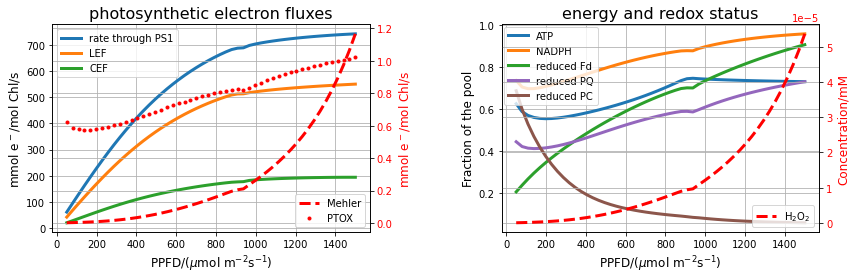

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_ppfd_petc_steady_state(v, ax1)
plot_ppfd_redox_steady_state(c, ax2)
fig.tight_layout(w_pad=5)
plt.savefig("fig-3.png", bbox_inches="tight")
plt.show()

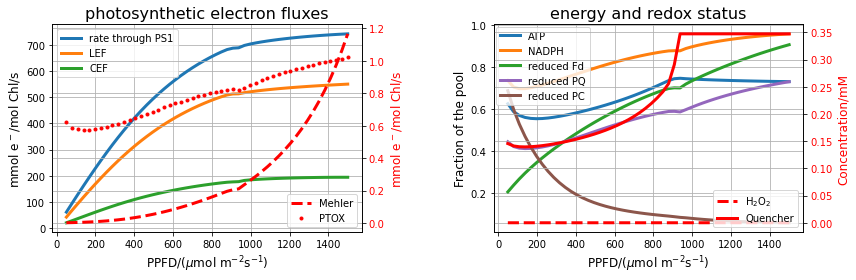

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_ppfd_petc_steady_state(v, ax1)
(ax21, ax22) = plot_ppfd_redox_steady_state(c, ax2)
ax22.plot(c["Q"], color="red", label="Quencher")
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
plt.savefig("fig-3-2.png", bbox_inches="tight")
plt.show()

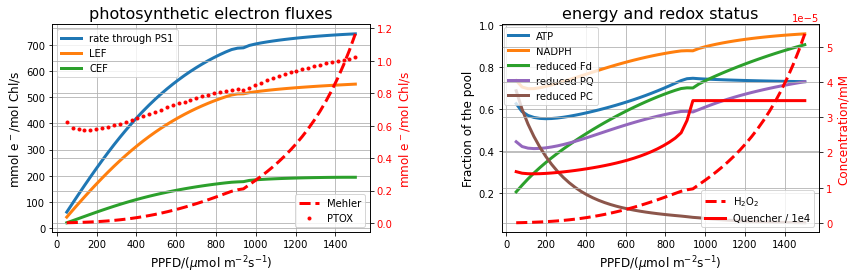

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_ppfd_petc_steady_state(v, ax1)
(ax21, ax22) = plot_ppfd_redox_steady_state(c, ax2)
ax22.plot(c["Q"] / 1e4, color="red", label="Quencher / 1e4")
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
plt.savefig("fig-3-3.png", bbox_inches="tight")
plt.show()

## Figure 4: Response under high light

In [13]:
def par_scan_osc(
    s: Simulator,
    par_name: str,
    par_values: Iterable[float],
    y0: dict[str, float],
    t_end: float = 100_000,
) -> Dict[str, pd.DataFrame]:
    cmin = {}
    cmax = {}
    cavg = {}
    vmin = {}
    vmax = {}
    vavg = {}
    for i, x in tqdm(enumerate(par_values), total=len(par_values)):
        s.initialise(y0)
        s.update_parameter(par_name, x)
        t, y = s.simulate(t_end)
        if t is None:
            all_compounds = s.model.get_all_compounds()
            rate_names = s.model.get_rate_names()
            cmin[x] = dict(zip(all_compounds, np.full(len(all_compounds), np.nan)))
            cmax[x] = dict(zip(all_compounds, np.full(len(all_compounds), np.nan)))
            cavg[x] = dict(zip(all_compounds, np.full(len(all_compounds), np.nan)))
            vmin[x] = dict(zip(rate_names, np.full(len(rate_names), np.nan)))
            vmax[x] = dict(zip(rate_names, np.full(len(rate_names), np.nan)))
            vavg[x] = dict(zip(rate_names, np.full(len(rate_names), np.nan)))
        else:
            cmin[x], cmax[x], vmin[x], vmax[x] = get_minmax(s, t_end)
            cavg[x], vavg[x] = get_avg(s, t_end)
            y0 = get_new_y0(s)
    return {
        "c_min": pd.DataFrame(cmin).T,
        "c_max": pd.DataFrame(cmax).T,
        "v_min": pd.DataFrame(vmin).T,
        "v_max": pd.DataFrame(vmax).T,
        "c_avg": pd.DataFrame(cavg).T,
        "v_avg": pd.DataFrame(vavg).T,
    }


def plot_avg_minmax(
    key: str,
    dfavg: pd.DataFrame,
    dfmin: pd.DataFrame,
    dfmax: pd.DataFrame,
    ax: plt.Axes,
    label: str,
    color: str,
    **plot_kwargs,
):
    dfavg[key].plot(
        ax=ax,
        color=color,
        label=label,
        **plot_kwargs,
    )
    dfmin[key].plot(
        ax=ax,
        style="--",
        color=color,
        label="_" + label,
        linewidth=1,
        **plot_kwargs,
    )
    dfmax[key].plot(
        ax=ax,
        style="--",
        color=color,
        label="_" + label,
        linewidth=1,
        **plot_kwargs,
    )


def plot_pgr5(
    v_avg: pd.DataFrame,
    v_min: pd.DataFrame,
    v_max: pd.DataFrame,
    c_avg: pd.DataFrame,
    c_min: pd.DataFrame,
    c_max: pd.DataFrame,
) -> Tuple[plt.Figure, plt.Axes]:
    fig, axs = plt.subplots(2, figsize=(12, 8), sharex=True)
    ax1, ax2 = axs.ravel()
    ax1b = ax1.twinx()

    plot_avg_minmax("vPS1", v_avg, v_min, v_max, ax1, "rate through PS1", "C0")
    plot_avg_minmax("vPS2", (2 * v_avg), (2 * v_min), (2 * v_max), ax1, "LEF", "C1")
    plot_avg_minmax("vCyc", (2 * v_avg), (2 * v_min), (2 * v_max), ax1, "CEF", "C2")
    plot_avg_minmax("ATP_norm", c_avg, c_min, c_max, ax2, "ATP", "C0")
    plot_avg_minmax("NADP_redoxstate", c_avg, c_min, c_max, ax2, "NADPH", "C1")
    plot_avg_minmax("Fd_redoxstate", c_avg, c_min, c_max, ax2, "Fd", "C2")
    plot_avg_minmax("PQ_redoxstate", c_avg, c_min, c_max, ax2, "PQ", "C3")
    plot_avg_minmax("PC_redoxstate", c_avg, c_min, c_max, ax2, "PC", "C4")

    plot_avg_minmax(
        "H2O2",
        (1000 * c_avg),
        (1000 * c_min),
        (1000 * c_max),
        ax1b,
        "steady state H$_2$O$_2$ concentration",
        "red",
    )

    ax1.set_title("electron flows and H$_2$O$_2$ production")
    ax1.set_ylabel("mmol e$^-$/mol Chl/s")

    ax1b.set_ylabel("H$_2$O$_2$/$\mu$M", color="red")
    ax1b.tick_params(axis="y", labelcolor="red")

    ax2.set_title("redox and energy states")
    ax2.set_xlabel("log$_2$-fold change in PGR5 activity")
    ax2.set_ylabel("fraction of total pool")

    for ax in axs.ravel():
        ax.legend(bbox_to_anchor=(1.2, 1))
    ax1b.legend(bbox_to_anchor=(1.2, 0.8))
    fig.tight_layout()
    return fig, ax

In [14]:
m = get_model()
s = Simulator(m)
s.initialise(y0)
s.update_parameter("pfd", 1000)

NUM_SCANS = 100
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
xscale = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)
kcyc_vals = m.parameters["kcyc"] * (2 ** xscale)

dfs = par_scan_osc(s, "kcyc", kcyc_vals, y0, t_end=2000)

for k, v in dfs.items():
    dfs[k] = v.set_index(xscale)

  0%|          | 0/100 [00:00<?, ?it/s]

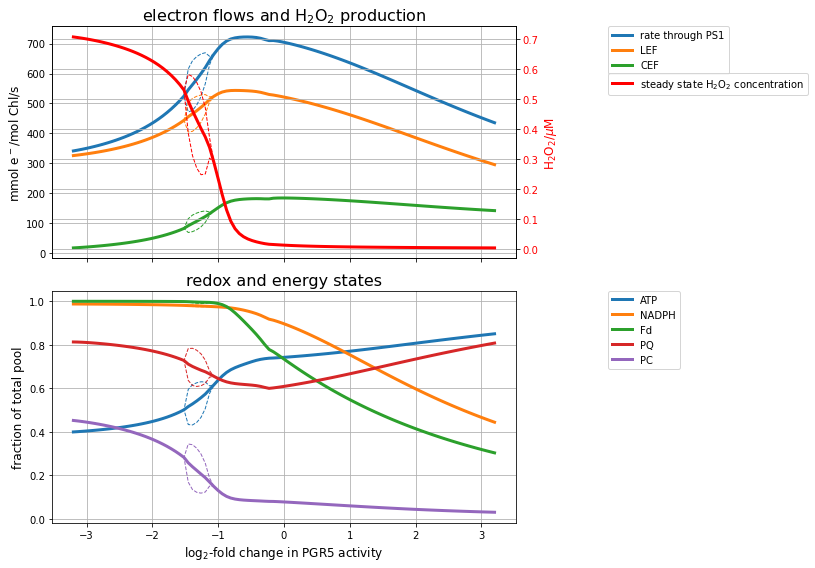

In [15]:
fig, ax = plot_pgr5(
    v_avg=dfs["v_avg"],
    v_min=dfs["v_min"],
    v_max=dfs["v_max"],
    c_avg=dfs["c_avg"],
    c_min=dfs["c_min"],
    c_max=dfs["c_max"],
)
plt.savefig("fig-4.png", bbox_inches="tight")

## Figure 5: PGR5 knockout

In [16]:
def light_simulation(
    s: Simulator,
    y0: dict[str, float],
    high_light: float = 1200,
    low_light: float = 40,
    t_low_light: float = 120,
    t_high_light: float = 30,
    n_light_switches: int = 5,
    t_pre: Optional[float] = None,
    t_post: Optional[float] = None,
):
    """Start with initial illumination at low light, then
    for n_light_switches
        simulate for t_high_light @ high_light
        simulate for t_low_light @ low_light
    """
    s.initialise(y0)
    s.update_parameter("pfd", low_light)
    if t_pre is None:
        t_end = 0
    else:
        t_end = t_pre
        s.simulate(t_end)
    for _ in tqdm(range(n_light_switches)):
        # High light
        t_end += t_high_light
        s.update_parameter("pfd", high_light)
        s.simulate(t_end)
        # Low light
        t_end += t_low_light
        s.update_parameter("pfd", low_light)
        s.simulate(t_end)
    if t_post is not None:
        t_end += t_post
        s.simulate(t_end)
    return s.get_full_results_df(), s.get_fluxes_df()


def shade_light(s: Simulator, axs: Union[plt.Axes, np.ndarray]):
    if not isinstance(axs, (list, np.ndarray)):
        axs = [axs]
    lights = [i["pfd"] for i in s.simulation_parameters]
    times = [(i[0], i[-1]) for i in s.time]
    max_pfd = max(lights)
    for ax in np.array(axs).flatten():
        for pfd, (t_start, t_end) in zip(lights, times):
            ax.axvspan(t_start, t_end, color=(0, 0, 0, 1 / 8 * (1 - pfd / max_pfd)))

In [17]:
m = get_model()

s1 = Simulator(m)
s1.initialise(y0)
s1.update_parameter("kcyc", 1.0)
c1, v1 = light_simulation(
    s1,
    y0,
    high_light=600,
    low_light=40,
    t_high_light=60,
    t_low_light=60,
    n_light_switches=5,
)

sm = Simulator(m)
sm.initialise(y0)
sm.update_parameter("kcyc", 0.0)
cm, vm = light_simulation(
    sm,
    y0,
    high_light=600,
    low_light=40,
    t_high_light=60,
    t_low_light=60,
    n_light_switches=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

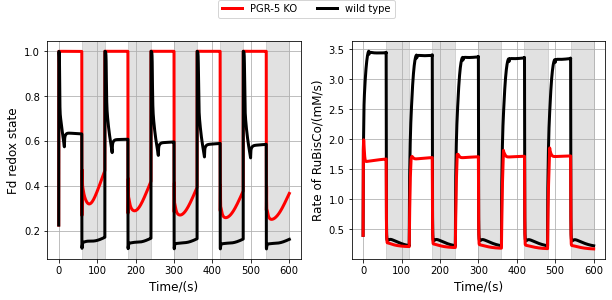

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
ax1.plot(cm["Fd_redoxstate"], label="PGR-5 KO", color="r")
ax1.plot(c1["Fd_redoxstate"], label="wild type", color="k")
ax1.set_ylabel("Fd redox state")
ax1.set_xlabel("Time/(s)")

ax2.plot(v1["vRuBisCO"], label="wild type", color="k")
ax2.plot(vm["vRuBisCO"], label="PGRL-5 KO", color="r")
ax2.set_ylabel("Rate of RuBisCo/(mM/s)")
ax2.set_xlabel("Time/(s)")

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)
shade_light(s1, ax1)
shade_light(s1, ax2)
plt.savefig("fig-5.png", bbox_inches="tight")
plt.show()

## Figure 6: Control coefficients

In [19]:
mca_parameters = {
    "PSIItot": "PS2",
    "PSItot": "PS1",
    "kCytb6f": r"b$_6$f",
    "kcyc": "PGR5",
    "kMehler": "Mehler",
    "V1_base": "RuBisCO",
    "V6_base": "FBPase",
    "V9_base": "SBPase",
    "kcatMDAR": "MDAR",
    "kcat_DHAR": "DHAR",
}

mca_reactions = {
    "vPS2": "PS2",
    "vPS1": "PS1",
    "vB6f": r"b$_6$f",
    "vMehler": "Mehler",
    "vCyc": "CEF",
    "vRuBisCO": "RuBisCO",
    "vFBPase": "FBPase",
    "v9": "SBPase",
    "vMDAreduct": "MDAR",
    "vDHAR": "DHAR",
}

mca_compounds = {
    "PQ_redoxstate": "PQ$_\mathrm{red}$",
    "Fd_redoxstate": "Fd$_\mathrm{red}$",
    "PC_redoxstate": "PC$_\mathrm{red}$",
    "NADP_redoxstate": "NADPH",
    "ATP_norm": "ATP",
    "RUBP": "RUBP",
    "PGA": "PGA",
    "FBP": "FBP",
    "SBP": "SBP",
}

In [20]:
s = Simulator(get_model())
s.initialise(y0)
s.update_parameter("pfd", 1000)
s.simulate_to_steady_state()
y0_1000 = get_new_y0(s)


s.initialise(y0)
s.update_parameter("pfd", 100)
s.simulate_to_steady_state()
y0_100 = get_new_y0(s)

In [21]:
m = get_model()
m.update_parameter("pfd", 1000)
ccc_1000, fcc_1000 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_1000,
    displacement=0.01,
)

m.update_parameter("pfd", 100)
ccc_100, fcc_100 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_100,
    displacement=0.01,
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

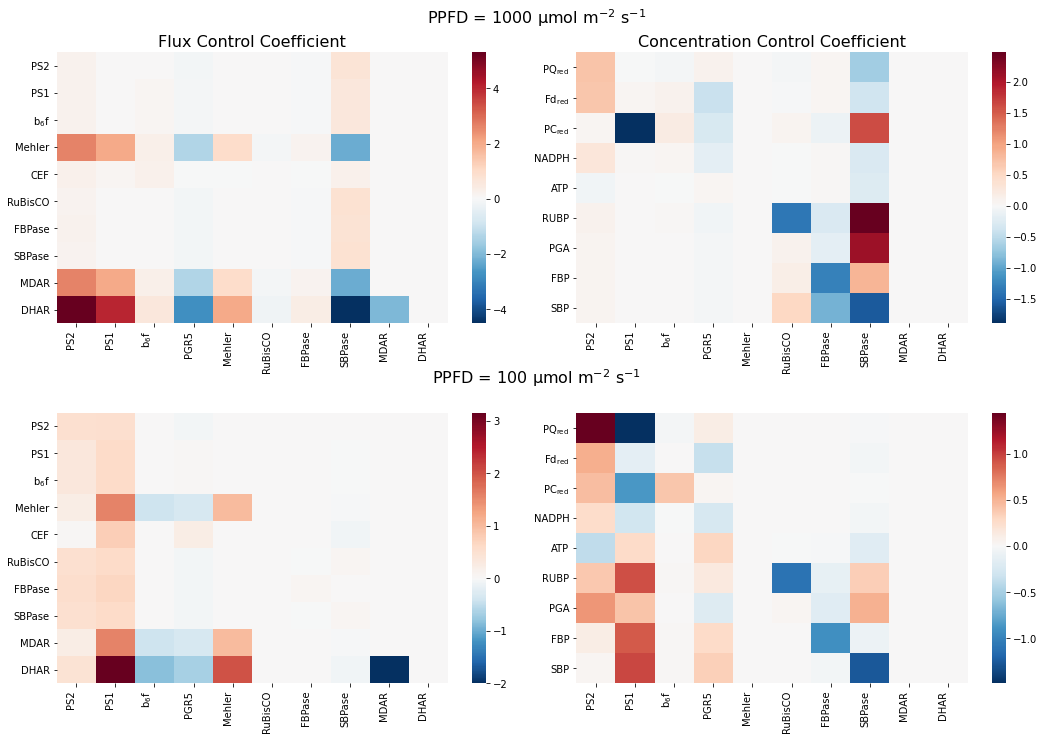

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
mca.plot_coefficient_heatmap(
    fcc_1000,
    title="Flux Control Coefficient",
    rows=mca_reactions,
    annotate=False,
    ax=ax1,
    norm=TwoSlopeNorm(0),
)
mca.plot_coefficient_heatmap(
    ccc_1000,
    title="Concentration Control Coefficient",
    rows=mca_compounds,
    annotate=False,
    ax=ax2,
    norm=TwoSlopeNorm(0),
)

ax1.set_xticklabels(mca_parameters.values(), rotation=90)
ax1.set_yticklabels(mca_reactions.values())
ax2.set_xticklabels(mca_parameters.values(), rotation=90)
ax2.set_yticklabels(mca_compounds.values())


mca.plot_coefficient_heatmap(
    fcc_100,
    title="",
    rows=mca_reactions,
    annotate=False,
    ax=ax3,
    norm=TwoSlopeNorm(0),
)
mca.plot_coefficient_heatmap(
    ccc_100,
    title="",
    rows=mca_compounds,
    annotate=False,
    ax=ax4,
    norm=TwoSlopeNorm(0),
)

ax3.set_xticklabels(mca_parameters.values(), rotation=90)
ax3.set_yticklabels(mca_reactions.values())
ax4.set_xticklabels(mca_parameters.values(), rotation=90)
ax4.set_yticklabels(mca_compounds.values())
fig.text(
    0.5, 1, "PPFD = 1000 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)
fig.text(
    0.5, 0.5, "PPFD = 100 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)

fig.tight_layout(h_pad=4)
plt.savefig("fig-6.png", bbox_inches="tight")
plt.show()

## Figure 7: CEF vs light intensity

In [6]:
def par_scan_osc_2d(
    s: Simulator,
    par_name1: str,
    par_values1: Iterable[float],
    par_name2: str,
    par_values2: Iterable[float],
    y0_loop: dict[str, float],
    t_end: float = 100_000,
) -> List[pd.DataFrame]:
    cmin = {}
    cmax = {}
    vmin = {}
    vmax = {}
    cavg = {}
    vavg = {}
    y0_outerloop = y0_loop
    for i, x1 in tqdm(enumerate(par_values1), total=len(par_values1)):
        cmin[x1] = {}
        cmax[x1] = {}
        vmin[x1] = {}
        vmax[x1] = {}
        cavg[x1] = {}
        vavg[x1] = {}
        s.update_parameter(par_name1, x1)
        for j, x2 in tqdm(enumerate(par_values2), total=len(par_values2)):
            if j == 0:
                s.initialise(y0_outerloop)
            else:
                s.initialise(y0_loop)

            s.update_parameter(par_name2, x2)
            t, y = s.simulate(t_end)
            if t is None:
                all_compounds = s.model.get_all_compounds()
                rate_names = s.model.get_rate_names()
                empty_cpds = pd.Series(
                    dict(zip(all_compounds, np.full(len(all_compounds), np.nan)))
                )
                empty_rates = pd.Series(
                    dict(zip(rate_names, np.full(len(rate_names), np.nan)))
                )
                cmin[x1][x2] = empty_cpds
                cmax[x1][x2] = empty_cpds
                cavg[x1][x2] = empty_cpds
                vmin[x1][x2] = empty_rates
                vmax[x1][x2] = empty_rates
                vavg[x1][x2] = empty_rates
            else:
                cmin[x1][x2], cmax[x1][x2], vmin[x1][x2], vmax[x1][x2] = get_minmax(
                    s, t_end
                )
                cavg[x1][x2], vavg[x1][x2] = get_avg(s, t_end)
                y0_loop = get_new_y0(s)

                if j == 0:
                    y0_outerloop = y0_loop

    multidfs = []
    mesh = np.meshgrid(par_values2, par_values1)
    colinds = [x.flatten() for x in mesh]
    for sol in (cmin, cmax, vmin, vmax, cavg, vavg):
        dfs = []
        for i in sol.keys():
            for j in sol[i].keys():
                dfs.append(sol[i][j])
        df3 = pd.DataFrame(
            data=np.array(dfs).T,
            index=dfs[0].index,
            columns=pd.MultiIndex.from_tuples(zip(*colinds)),
        )
        multidfs.append(df3)
    return multidfs

In [7]:
m = get_model()
s = Simulator(m)
s.initialise(y0)

NUM_SCANS = 20
MIN_LOG_F = -3.2
MAX_LOG_F = 3.2
xscale = np.linspace(MIN_LOG_F, MAX_LOG_F, NUM_SCANS)

pfd_vals = np.linspace(40, 1500, 20)
kcyc_vals = m.parameters["kcyc"] * (2 ** xscale)

mdfs_cyc = par_scan_osc_2d(s, "pfd", pfd_vals, "kcyc", kcyc_vals, y0, t_end=2000)
(cmin, cmax, vmin, vmax, cavg, vavg) = mdfs_cyc

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

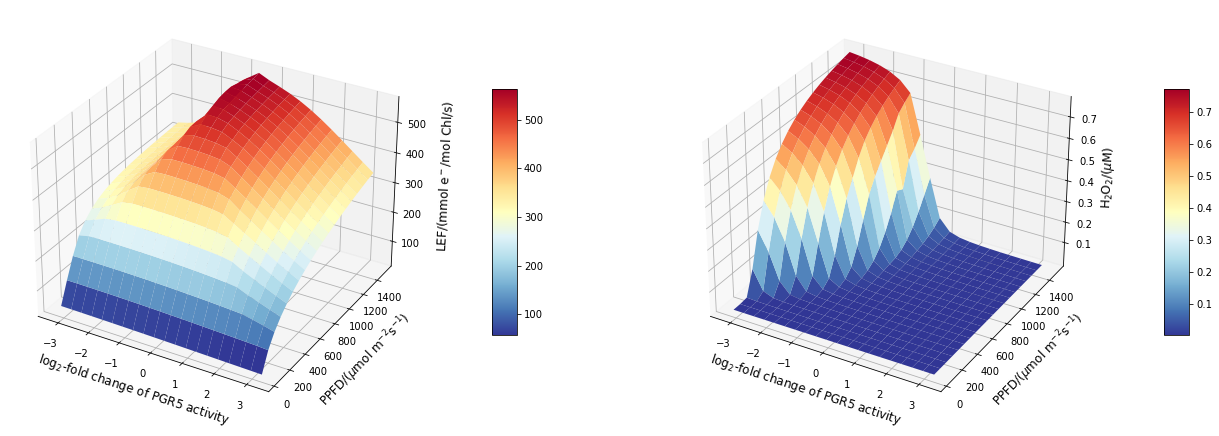

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={"projection": "3d"})

ax = ax1
surf = ax.plot_surface(
    *np.meshgrid(xscale, pfd_vals),
    2 * np.array(vavg.loc["vPS2"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("log$_2$-fold change of PGR5 activity", labelpad=5)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", labelpad=10)
ax.set_zlabel("LEF/(mmol e$^-$/mol Chl/s)", labelpad=10)
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)

ax = ax2
surf = ax.plot_surface(
    *np.meshgrid(xscale, pfd_vals),
    1000 * np.array(cavg.loc["H2O2"]).reshape(20, 20),
    cmap="RdYlBu_r",
    edgecolor="none",
)
ax.set_xlabel("log$_2$-fold change of PGR5 activity", labelpad=5)
ax.set_ylabel("PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", labelpad=10)
ax.set_zlabel("H$_2$O$_2$/($\mu$M)")
fig.colorbar(surf, shrink=0.6, aspect=10, ax=ax, pad=0.1)
fig.tight_layout()
plt.savefig("fig-7.png", bbox_inches="tight")